In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from transformers import BertTokenizer
import torch
from transformers import BertForSequenceClassification, AdamW

### Задание

Откройте новый ноутбук на kaggle (слева вкладка Code -> New Notebook). Через "+ Add data" справа найдите и добавьте набор данных IMDB Dataset of 50K Movie Reviews.

In [3]:
np.random.seed(101)

df = pd.read_csv('../input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
df['sentiment'] = df['sentiment'].replace({'positive': 1, 'negative': 0})
df = df.sample(2000)
df.reset_index(drop=True, inplace=True)

In [4]:
df.head()

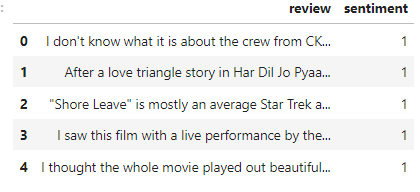

In [5]:
df['sentiment'].value_counts().plot(kind='bar')
plt.show()

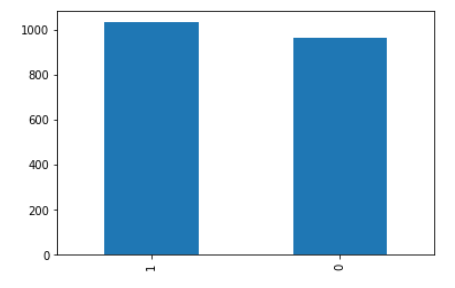

Напишите класс `IMDbDataset`, который на вход принимает тексты и метки класса (`texts`, `labels`). Указания:
1. Под `__init__` преобразуйте `pandas.Series` с текстами в список текстов (`tokenizer` требует, чтобы тексты были представлены в виде списка).
2. К полученному списку текстов примените `tokenizer` аналогично примеру выше. Получите `self.input_ids`, `self.attention_masks`, `self.labels = labels`.
3. Метод `__len__` должен возвращать длину датасета (`len(self.labels)`).
4. Метод `__getitem__` должен взвращать `input_ids`, `attention_masks`, и `labels` для каждого примера.

In [6]:
from torch.utils.data import Dataset, DataLoader

class IMDbDataset(Dataset):
    def __init__(self, texts, labels):
        # Ваш код здесь
        texts=texts.values.tolist()
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.encoding = tokenizer(texts, return_tensors='pt', padding=True, truncation=True)
        self.input_ids = self.encoding['input_ids']
        self.attention_mask = self.encoding['attention_mask']
        self.labels = labels

    def __len__(self):
        # Ваш код здесь
        return len(self.labels)
        
        
    def __getitem__(self, idx):
        # Ваш код здесь
        return self.input_ids[idx],self.attention_mask[idx],self.labels[idx]
        

Следующий код должен выполняться без ошибок, если всё сделано правильно:

In [7]:
train_dataset = IMDbDataset(df['review'], df['sentiment'].values)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Определите модель аналогично примеру выше и перенесите её на device. Позже не забудьте перед обучением включить GPU в ноутбуке.
Обучать будем методом AdamW. Установите шаг обучения равным 2e-3.
Количество эпох задайте равным 10.
Обучите модель. Каждые 10 мини-батчей выводите среднее значение функции потерь по данным 10 мини-батчам. В отдельной переменной сохраняйте значение функции потерь на каждой из эпох.

In [9]:
torch.manual_seed(101)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', return_dict=True).to(device)
model.train()

for param in model.base_model.parameters():
    param.requires_grad = False

optimizer = AdamW(model.parameters(), lr=2e-3)
n_epochs = 10
train_len = len(train_loader)

batch_losses =list()
epoch_losses = list()
for epoch in range(1, n_epochs+1):
    batch_loss = 0
    epoch_loss = 0
    for step, (input_ids, attention_mask, labels) in enumerate(train_loader):
        model.zero_grad()
        
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.unsqueeze(0)
        labels = labels.to(device)
        
        # Ваш код здесь

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        loss.backward()
        optimizer.step()
        
        batch_loss = batch_loss+loss.item()
        if (step+1) % 10 ==0:
            batch_losses.append(batch_loss/10)
            batch_loss = 0
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
            .format(epoch, n_epochs, step+1, train_len, loss.item()))
        
        epoch_loss=epoch_loss++loss.item()
        
    epoch_losses.append(epoch_loss/train_len)

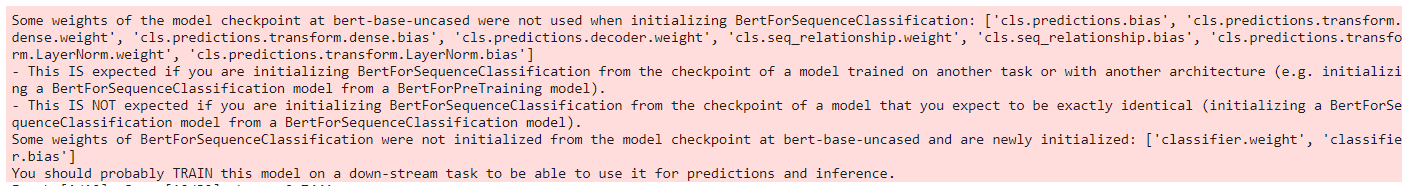

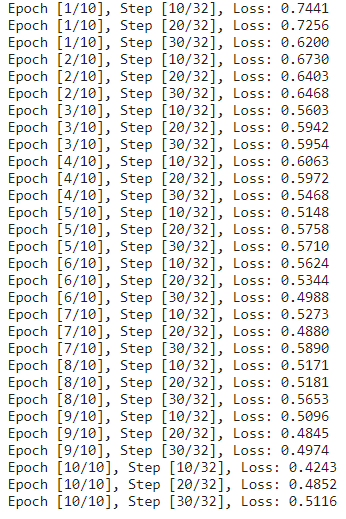

Выведите графики процесса обучения `batch_losses` и `epoch_losses`.

In [10]:
plt.plot(batch_losses)

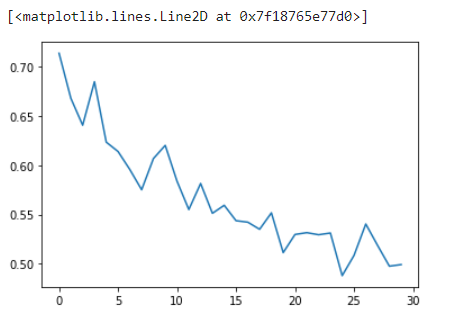

In [11]:
plt.plot(epoch_losses)

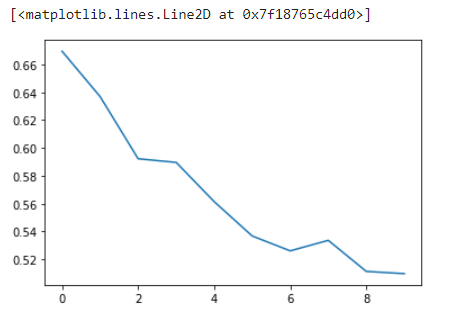